### Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pylab as plt

from tensorflow.keras import utils
from sklearn.metrics import f1_score
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load Data

In [4]:
# Load Data
pre_images, labels = load_galaxy10sdss()

C:\Users\weigfan\.astroNN\datasets\Galaxy10.h5 was found!


In [5]:
# Inspect data
print("pre_images.shape:", pre_images.shape)
print("labels.shape:", labels.shape)

pre_images.shape: (21785, 69, 69, 3)
labels.shape: (21785,)


### Inspect Data

===================Data Inspection===================


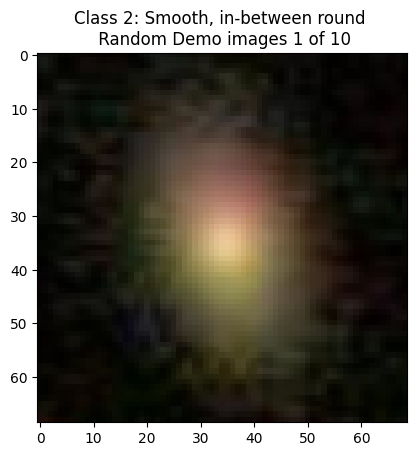

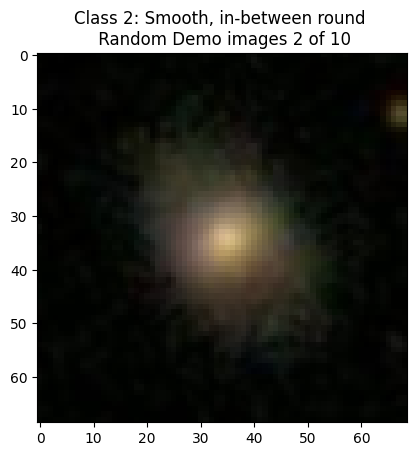

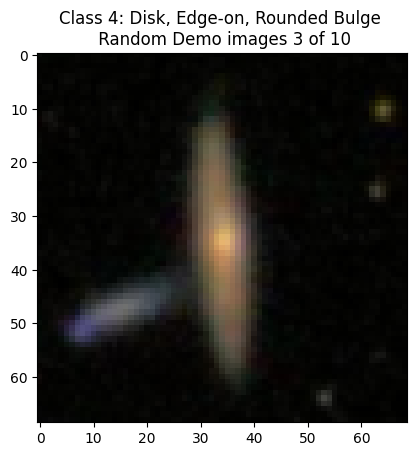

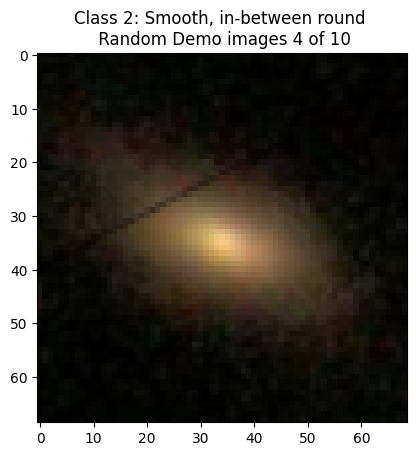

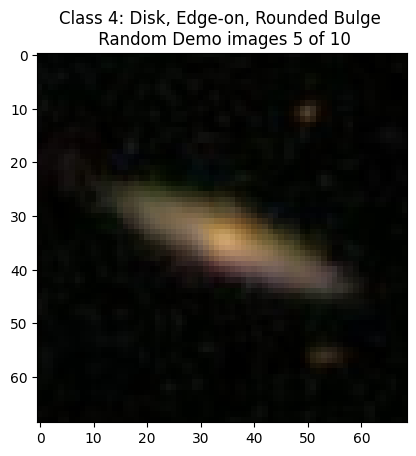

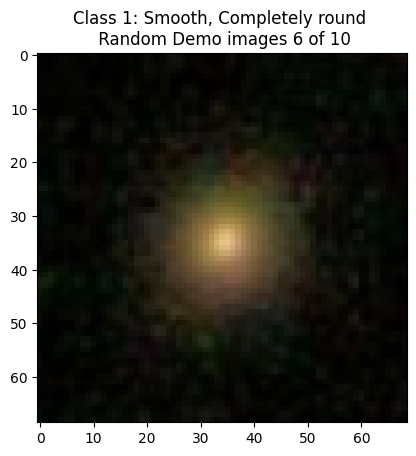

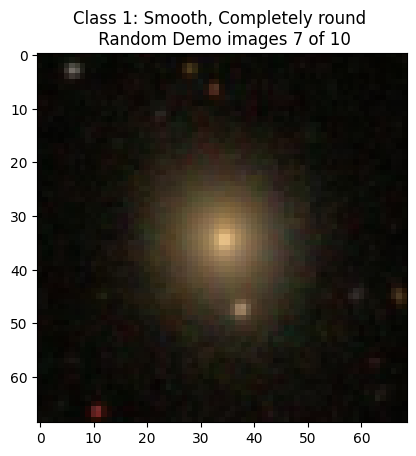

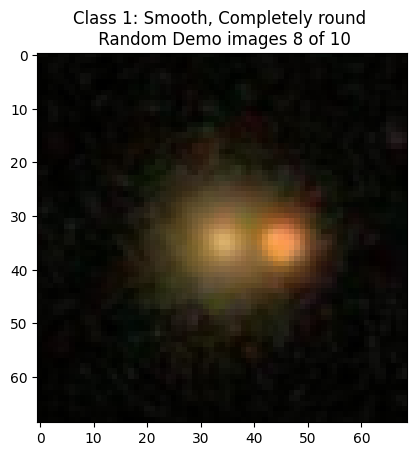

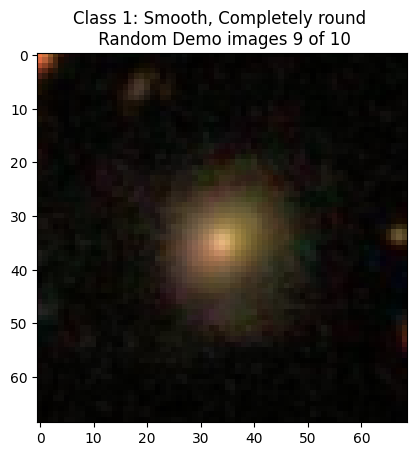

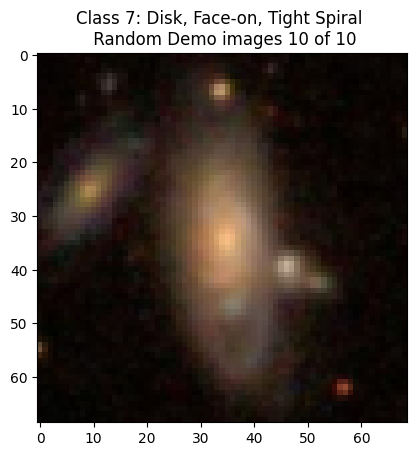

===============Data Inspection Finished===============


In [11]:
# Select 10 of the images to inspect
img = None
plt.ion()
print('===================Data Inspection===================')
for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
    img = plt.imshow(images[i])
    plt.title('Class {}: {} \n Random Demo images {} of 10'.format(np.argmax(labels[i]), galaxy10cls_lookup(labels[i]), counter+1))
    plt.draw()
    plt.pause(2.)
plt.close('all')
print('===============Data Inspection Finished===============')

### Train

In [6]:
# Num classes
num_classes = 10

In [7]:
# One-hot Encode
labels = utils.to_categorical(labels, 10)

# Normalize the images to [0, 1]
images = pre_images.astype(np.float32) / 255.0
labels = labels.astype(np.float32)

# Train/Test Split
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1, random_state=20050531)
train_images, train_labels = images[train_idx], labels[train_idx]
test_images, test_labels = images[test_idx], labels[test_idx]
print(f"Train labels shape: {train_labels.shape}, Test labels shape: {test_labels.shape}")

Train labels shape: (19606, 10), Test labels shape: (2179, 10)


In [7]:
# CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional layer
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # First dense layer
        layers.Dense(256, activation='relu'),
        
        # Output layer for multiclass classification
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:
# Create the model
input_shape = (69, 69, 3)
cnn_model = create_cnn_model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
cnn_model.fit(train_images, train_labels, epochs=10, batch_size=32)
cnn_model.summary()

Epoch 1/10
613/613 [==============================] - 19s 14ms/step - loss: 1.2479 - accuracy: 0.4974
Epoch 2/10
613/613 [==============================] - 8s 14ms/step - loss: 0.8578 - accuracy: 0.6809
Epoch 3/10
613/613 [==============================] - 8s 13ms/step - loss: 0.6820 - accuracy: 0.7508
Epoch 4/10
613/613 [==============================] - 8s 14ms/step - loss: 0.5918 - accuracy: 0.7825
Epoch 5/10
613/613 [==============================] - 8s 13ms/step - loss: 0.5298 - accuracy: 0.8031
Epoch 6/10
613/613 [==============================] - 8s 13ms/step - loss: 0.4847 - accuracy: 0.8221
Epoch 7/10
613/613 [==============================] - 8s 14ms/step - loss: 0.4448 - accuracy: 0.8363
Epoch 8/10
613/613 [==============================] - 8s 13ms/step - loss: 0.3979 - accuracy: 0.8539
Epoch 9/10
613/613 [==============================] - 8s 14ms/step - loss: 0.3615 - accuracy: 0.8668
Epoch 10/10
613/613 [==============================] - 8s 13ms/step - loss: 0.3284 - accur

### Evaluate

In [2]:
# # Load model
# cnn_model = load_model("cnn_model.h5")

In [8]:
# Predict
predicted_labels = cnn_model.predict(test_images)

# Convert predicted_labels to class
prediction_class = np.argmax(predicted_labels, axis=1)

# Convert test_labels to class
test_class = np.argmax(test_labels, axis=1)

69/69 [==============================] - 6s 6ms/step


In [9]:
# Prediction class
prediction_class[:10]

array([8, 2, 8, 1, 1, 0, 1, 2, 1, 2], dtype=int64)

In [11]:
# Test class
test_class[:10]

array([8, 2, 8, 1, 1, 0, 1, 2, 1, 0], dtype=int64)

In [10]:
# Compute F1 score
y_pred = prediction_class
y_true = test_class
f1_weighted = f1_score(y_true, y_pred, average='micro')
print(f"Micro F1: {f1_weighted}")

Micro F1: 0.794401101422671


### Save

In [11]:
# Save
cnn_model.save("cnn_model.h5")